In [1]:
#%% Imports
import os
import shutil
import nibabel as nib
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as st
import nilearn
import pandas as pd

from scipy.stats.stats import pearsonr
from matplotlib.colors import colorConverter
from glob import glob
from scipy import ndimage
from nilearn.image import resample_to_img, resample_img
from nilearn.masking import compute_background_mask, compute_epi_mask
from nilearn.plotting import plot_roi, plot_epi, plot_img, plot_anat
from scipy.spatial.distance import directed_hausdorff
from nipype.algorithms.metrics import Distance
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from scipy import interp
from itertools import chain
from scipy.ndimage.morphology import binary_dilation, binary_erosion, binary_closing, binary_opening
from skimage.morphology import cube, octahedron, ball

In [2]:
def get_metrics(original_path, predicted_path, mask_path, th=None):
    original_data = nib.load(original_path).get_data()
    predicted_data = nib.load(predicted_path).get_data()
    mask_data = nib.load(mask_path).get_data() # use mask to limit results to the brain
    
    # Threshold data if necessary
    if th is not None:
        predicted_data = (predicted_data > th).astype(int)
    
    metrics = {}
    
    # Real positive cases
    metrics['P'] = float(np.sum((original_data == 1).astype(int) * mask_data))

    # Real negative cases
    metrics['N'] = float(np.sum((original_data == 0).astype(int) * mask_data))

    # True positive
    metrics['TP'] = float(np.sum((((predicted_data == 1).astype(int) +
                                   (original_data == 1).astype(int)) * mask_data) == 2))

    # True negative
    metrics['TN'] = float(np.sum((((predicted_data == 0).astype(int) +
                                   (original_data == 0).astype(int)) * mask_data) == 2))

    # False positive (all 1's in predicted minus original 1's)
    metrics['FP'] = float(np.sum((((predicted_data == 1).astype(int) -
                                   (original_data == 1).astype(int)) * mask_data) == 1))

    # False negative
    metrics['FN'] = float(np.sum((((predicted_data == 1).astype(int) -
                                   (original_data == 1).astype(int)) * mask_data) == -1))

    # True positive rate (Sensitivity, Recall)
    metrics['TPR'] = metrics['TP'] / (metrics['TP'] + metrics['FN'])  

    # True negative rate (Specificity)
    metrics['TNR'] = metrics['TN'] / (metrics['TN'] + metrics['FP'])

    # Positive predictive value (Precision)
    metrics['PPV'] = metrics['TP'] / (metrics['TP'] + metrics['FP'])

    # Negative predictive value
    metrics['NPV'] = metrics['TN'] / (metrics['TN'] + metrics['FN'])

    # False negative rate (Miss rate)
    metrics['FNR'] = 1 -  metrics['TPR']

    # False positive rate (Fall-out)
    metrics['FPR'] = 1 - metrics['TNR']

    # False discovery rate
    metrics['FDR'] = 1 - metrics['PPV']

    # False omission rate
    metrics['FOR'] = 1 - metrics['NPV']

    # Accuracy
    metrics['ACC'] = (metrics['TP'] + metrics['TN']) / \
                                (metrics['TP'] + 
                                 metrics['TN'] + 
                                 metrics['FP'] + 
                                 metrics['FN'])

    # F1 Score (also known as DSC, Sørensen–Dice coefficient, ...)
    #metrics['F1S'] = 2 * (metrics['PPV'] * metrics['TPR']) / \
    #                                (metrics['PPV'] + metrics['TPR'])
    metrics['F1S'] = (2*metrics['TP']) / (2*metrics['TP'] + metrics['FP'] + metrics['FN'])

    # Matthews correlation coefficient
    # The MCC can be more appropriate when negatives actually mean something,
    # and can be more useful in other ways.
    metrics['MCC'] = ((metrics['TP'] * metrics['TN']) - (metrics['FP'] * metrics['FN'])) / \
                        np.sqrt(
                            (metrics['TP'] + metrics['FP']) *
                            (metrics['TP'] + metrics['FN']) *
                            (metrics['TN'] + metrics['FP']) *
                            (metrics['TN'] + metrics['FN']))

    # Compute Hausdorff distance
    D = Distance()
    if th is not None:
        try:
            metrics['HD'] = D._eucl_max(nib.load(original_path),
                                        nib.Nifti1Image(predicted_data, nib.load(predicted_path).affine))
        except:
            metrics['HD'] = float('nan')
    else:
        metrics['HD'] = D._eucl_max(nib.load(original_path), nib.load(predicted_path))

    # Compute Jaccard index
    metrics['JI'] = metrics['TP'] / (metrics['FN'] + metrics['FP'] + metrics['TP'])

    # Informedness or Bookmaker informedness
    metrics['BM'] = metrics['TPR'] + metrics['TNR'] - 1

    #Markedness
    metrics['MK'] = metrics['PPV'] + metrics['NPV'] - 1

    
    return(metrics)
    

In [3]:
# Set working directory
os.chdir('/home/uziel/DISS')
#os.chdir('/media/uziel/Pulga 2/DISS')
# Set root of models to be post-processed
root = "/media/uziel/Pulga2/DISS/milestones_6"
model_variant = 'DM_V4_[0-4]' # choose model variant. Eg. "DM_V0_[0-4]".
tmp = model_variant.split('_')
if len(tmp) == 3:
    model_name = tmp[1]
elif len(tmp) == 4:
    model_name = tmp[1] + '_' + tmp[2]
else:
    model_name = tmp[1] + '_' + tmp[2] + '_' + tmp[3]
    
# Load all trained models (k-folds) of model_variant
trained_models = sorted(glob(os.path.join(root, model_variant)))

**POSTPROCESSING** for test cases

Upsample predicted labels and compute test metrics

In [ ]:
##################################################################
##### POSTPROCESSING FOR K-FOLD CROSS-VALIDATION MODELS (0) ######
##################################################################

root_data = './data/ISLES2017/training'
root_data_processed = './data_processed/ISLES2017/training'
test_results = {}

for model in trained_models:
    root_1 = os.path.join(model, 'output/predictions/testSession/predictions')
    root_2 = os.path.dirname(root_1)
    
    # Load label predictions
    preds = sorted(glob(os.path.join(root_1, '*Segm.nii.gz')))
    # Load probability maps of background
    pmap_0 = sorted(glob(os.path.join(root_1, '*ProbMapClass0.nii.gz')))
    # Load probability maps of foreground
    pmap_1 = sorted(glob(os.path.join(root_1, '*ProbMapClass1.nii.gz')))
    
    test_results[os.path.basename(model)] = []
    
    # resize its prediction for final result validation
    for i in range(len(preds)):
        # Find subject that contains the code in pred.
        subject = sorted([y
                          for x in os.walk(root_data)
                          for y in glob(os.path.join(x[0], '*'))
                          if os.path.basename(preds[i]).split('_')[-2].split('.')[-1] in y
                         ])[0].split('/')[-2]

        subject_channels = sorted([y
                                   for x in os.walk(os.path.join(root_data, subject))
                                   for y in glob(os.path.join(x[0], '*MR_*.nii'))
                                   if '4DPWI' not in y
                                  ])
        
        subject_label = sorted([y
                                for x in os.walk(os.path.join(root_data, subject))
                                for y in glob(os.path.join(x[0], '*OT*.nii'))
                               ])[0]

        subject_processed = sorted([y
                                    for x in os.walk(root_data_processed)
                                    for y in glob(os.path.join(x[0], '*'))
                                    if os.path.basename(preds[i]).split('_')[-2].split('.')[-1] in y
                                   ])[0].split('/')[-2]
        
        subject_mask = sorted([y
                               for x in os.walk(os.path.join(root_data_processed, subject_processed))
                               for y in glob(os.path.join(x[0], '*mask*'))
                              ])[0]
        
        # Load ADC channel as reference
        original_img = nib.load(subject_channels[0])

        # Load predictions and prob maps
        pred_img = nib.load(preds[i])
        pmap_0_img = nib.load(pmap_0[i])
        pmap_1_img = nib.load(pmap_1[i])
        
        # Upsample to original size
        pred_img = resample_img(pred_img,
                                original_img.affine,
                                original_img.shape,
                                interpolation='nearest')
        
        pmap_0_img = resample_img(pmap_0_img,
                                  original_img.affine,
                                  original_img.shape,
                                  interpolation='continuous')
        
        pmap_1_img = resample_img(pmap_1_img,
                                  original_img.affine,
                                  original_img.shape,
                                  interpolation='continuous')
        
        # Load subject mask
        mask_img = nib.load(subject_mask)
        
        # Upsample to original size
        mask_img = resample_img(mask_img,
                                original_img.affine,
                                original_img.shape,
                                interpolation='nearest')
        
        # Save prediction
        pred_path = os.path.join(root_2, "_".join(os.path.basename(preds[i]).split('_')[:-1]) + '.pred.nii')
        pmap_0_path = os.path.join(root_2, "_".join(os.path.basename(pmap_0[i]).split('_')[:-1]) + '.pmap_0.nii')
        pmap_1_path = os.path.join(root_2, "_".join(os.path.basename(pmap_1[i]).split('_')[:-1]) + '.pmap_1.nii')
        mask_path = os.path.join(root_2, "_".join(os.path.basename(pmap_1[i]).split('_')[:-1]) + '.mask.nii')
        
        nib.save(pred_img, pred_path)
        nib.save(pmap_0_img, pmap_0_path)
        nib.save(pmap_1_img, pmap_1_path)
        nib.save(mask_img, mask_path)
        
        # Compute metrics between original and predicted label
        metrics = get_metrics(subject_label, pred_path, mask_path)
        
        test_results[os.path.basename(model)].append([subject,
                                                      subject_channels,
                                                      subject_label,
                                                      pred_path,
                                                      pmap_0_path,
                                                      pmap_1_path,
                                                      mask_path,
                                                      metrics])
        
    # Save model results
    with open(os.path.join(model, 'test_results.pkl'), 'wb') as output:
        pickle.dump(test_results[os.path.basename(model)], output, pickle.HIGHEST_PROTOCOL)
        
    # Compute mean and std of model subjects predictions' metrics
    metrics = np.array(test_results[os.path.basename(model)])[:,7]
    test_metrics = {}
    test_metrics['mean'] = {k : np.mean([t[k] for t in metrics]) for k in metrics[0]}
    test_metrics['std'] = {k : np.std([t[k] for t in metrics]) for k in metrics[0]}
    
    # Save each model's metrics
    with open(os.path.join(model, 'test_metrics.pkl'), 'wb') as output:
        pickle.dump(test_metrics, output, pickle.HIGHEST_PROTOCOL)

# Save all models' results
with open(os.path.join(root, model_name + '_test_results.pkl'), 'wb') as output:
    pickle.dump(test_results, output, pickle.HIGHEST_PROTOCOL)

Load each model's metrics, compute mean and std. This is the final result of an experiment, and determines its performance.

In [ ]:
metrics = []
for model in trained_models:
    with open(os.path.join(model, 'test_metrics.pkl'), 'rb') as input:
        metrics.append(pickle.load(input))

metrics = np.array(metrics)
test_metrics['mean'] = {k : np.mean([t['mean'][k] for t in metrics]) for k in metrics[0]['mean']}
test_metrics['std'] = {k : np.std([t['std'][k] for t in metrics]) for k in metrics[0]['std']}

# Save final experiment metrics
with open(os.path.join(root, model_name + '_test_metrics.pkl'), 'wb') as output:
    pickle.dump(test_metrics, output, pickle.HIGHEST_PROTOCOL)

**ROC CURVE** for test cases

In [ ]:
model_mean_fpr = {}
model_mean_tpr = {}
model_mean_auc = {}
for model in trained_models:
    original_data = []
    predicted_data = []
    for _, _, subject_label, _, _, pmap_1_path, _, _ in test_results[os.path.basename(model)]:
        original_data.append(nib.load(subject_label).get_data().ravel())
        predicted_data.append(nib.load(pmap_1_path).get_data().ravel())

    # Join all subjects to perform micro-average
    y_true = list(chain.from_iterable(original_data))
    y_pred = list(chain.from_iterable(predicted_data))
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    
    model_mean_fpr[os.path.basename(model)] = fpr
    model_mean_tpr[os.path.basename(model)] = tpr
    model_mean_auc[os.path.basename(model)] = auc(fpr, tpr)

In [ ]:
plt.figure(figsize=(4, 4))
lw = 2
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for model in trained_models:
    tprs.append(interp(mean_fpr, model_mean_fpr[os.path.basename(model)], model_mean_tpr[os.path.basename(model)]))
    aucs.append(model_mean_auc[os.path.basename(model)])
    plt.plot(model_mean_fpr[os.path.basename(model)], model_mean_tpr[os.path.basename(model)], lw=1, alpha=0.3,
             label = 'Fold {0} (AUC = {1:0.2f})'
             ''.format(os.path.basename(model).split('_')[-1], model_mean_auc[os.path.basename(model)]))


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)
plt.plot([0, 1], [1, 0], 'k:', lw=lw, label = 'EER')

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('FPR', size=15)
plt.ylabel('TPR', size=15)
plt.title('ROC curve (' + model_name + ')')
plt.legend(loc='lower right', fontsize=8)
plt.savefig(os.path.join(root, model_name + '_test_roc.pdf'), bbox_inches='tight')

**PRECISION-RECALL CURVE** for test cases

In [ ]:
model_mean_precision = {}
model_mean_recall = {}
model_mean_ap = {}
for model in trained_models:
    original_data = []
    predicted_data = []
    for _, _, subject_label, _, _, pmap_1_path, _, _ in test_results[os.path.basename(model)]:
        original_data.append(nib.load(subject_label).get_data().ravel())
        predicted_data.append(nib.load(pmap_1_path).get_data().ravel())

    # Join all subjects to perform micro-average
    y_true = list(chain.from_iterable(original_data))
    y_pred = list(chain.from_iterable(predicted_data))
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    average_precision = average_precision_score(y_true, y_pred)
    
    model_mean_precision[os.path.basename(model)] = precision
    model_mean_recall[os.path.basename(model)] = recall
    model_mean_ap[os.path.basename(model)] = average_precision

In [ ]:
plt.figure(figsize=(4,4))

f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('F1S={0:0.1f}'.format(f_score), xy=(0.8, y[45] + 0.02))
    
lines.append(l)
labels.append('iso-F1S curves')
lw = 2
for model in trained_models:
    l, = plt.plot(model_mean_recall[os.path.basename(model)],
                  model_mean_precision[os.path.basename(model)],
                  lw=lw)
    lines.append(l)
    labels.append('Fold {0} (AP = {1:0.2f})'
                  ''.format(os.path.basename(model).split('_')[-1],
                            model_mean_ap[os.path.basename(model)]))

#fig = plt.gcf()
#fig.subplots_adjust(bottom=0.25)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('Recall (TPR)', size=15)
plt.ylabel('Precision (PPV)', size=15)
plt.title('PR curve (' + model_name + ')')
plt.legend(lines, labels, loc='lower left', fontsize=8)
plt.savefig(os.path.join(root, model_name + '_test_pr.pdf'), bbox_inches='tight')

**POSTPROCESSING** for validation cases

Upsample predicted labels and compute validation metrics

In [ ]:
##################################################################
##### POSTPROCESSING FOR K-FOLD CROSS-VALIDATION MODELS (0) ######
##################################################################

root_data = './data/ISLES2017/training'
root_data_processed = './data_processed/ISLES2017/training'
val_results = {}

for model in trained_models:
    root_1 = os.path.join(model, 'output/predictions/valSession/predictions')
    root_2 = os.path.dirname(root_1)
    
    # Load label predictions
    preds = sorted(glob(os.path.join(root_1, '*Segm.nii.gz')))
    # Load probability maps of background
    pmap_0 = sorted(glob(os.path.join(root_1, '*ProbMapClass0.nii.gz')))
    # Load probability maps of foreground
    pmap_1 = sorted(glob(os.path.join(root_1, '*ProbMapClass1.nii.gz')))
    
    val_results[os.path.basename(model)] = []
    
    # resize its prediction for final result validation
    for i in range(len(preds)):
        # Find subject that contains the code in pred.
        subject = sorted([y
                          for x in os.walk(root_data)
                          for y in glob(os.path.join(x[0], '*'))
                          if os.path.basename(preds[i]).split('_')[-2].split('.')[-1] in y
                         ])[0].split('/')[-2]

        subject_channels = sorted([y
                                   for x in os.walk(os.path.join(root_data, subject))
                                   for y in glob(os.path.join(x[0], '*MR_*.nii'))
                                   if '4DPWI' not in y
                                  ])
        
        subject_label = sorted([y
                                for x in os.walk(os.path.join(root_data, subject))
                                for y in glob(os.path.join(x[0], '*OT*.nii'))
                               ])[0]

        subject_processed = sorted([y
                                    for x in os.walk(root_data_processed)
                                    for y in glob(os.path.join(x[0], '*'))
                                    if os.path.basename(preds[i]).split('_')[-2].split('.')[-1] in y
                                   ])[0].split('/')[-2]
        
        subject_mask = sorted([y
                               for x in os.walk(os.path.join(root_data_processed, subject_processed))
                               for y in glob(os.path.join(x[0], '*mask*'))
                              ])[0]
        
        # Load ADC channel as reference
        original_img = nib.load(subject_channels[0])

        # Load predictions and prob maps
        pred_img = nib.load(preds[i])
        pmap_0_img = nib.load(pmap_0[i])
        pmap_1_img = nib.load(pmap_1[i])
        
        # Upsample to original size
        pred_img = resample_img(pred_img,
                                original_img.affine,
                                original_img.shape,
                                interpolation='nearest')
        
        pmap_0_img = resample_img(pmap_0_img,
                                  original_img.affine,
                                  original_img.shape,
                                  interpolation='continuous')
        
        pmap_1_img = resample_img(pmap_1_img,
                                  original_img.affine,
                                  original_img.shape,
                                  interpolation='continuous')
        
        # Load subject mask
        mask_img = nib.load(subject_mask)
        
        # Upsample to original size
        mask_img = resample_img(mask_img,
                                original_img.affine,
                                original_img.shape,
                                interpolation='nearest')
        
        # Save prediction
        pred_path = os.path.join(root_2, "_".join(os.path.basename(preds[i]).split('_')[:-1]) + '.pred.nii')
        pmap_0_path = os.path.join(root_2, "_".join(os.path.basename(pmap_0[i]).split('_')[:-1]) + '.pmap_0.nii')
        pmap_1_path = os.path.join(root_2, "_".join(os.path.basename(pmap_1[i]).split('_')[:-1]) + '.pmap_1.nii')
        mask_path = os.path.join(root_2, "_".join(os.path.basename(pmap_1[i]).split('_')[:-1]) + '.mask.nii')
        
        nib.save(pred_img, pred_path)
        nib.save(pmap_0_img, pmap_0_path)
        nib.save(pmap_1_img, pmap_1_path)
        nib.save(mask_img, mask_path)
        
        # Compute metrics between original and predicted label
        metrics = get_metrics(subject_label, pred_path, mask_path)
        
        val_results[os.path.basename(model)].append([subject,
                                                     subject_channels,
                                                     subject_label,
                                                     pred_path,
                                                     pmap_0_path,
                                                     pmap_1_path,
                                                     mask_path,
                                                     metrics])
        
    # Save model results
    with open(os.path.join(model, 'val_results.pkl'), 'wb') as output:
        pickle.dump(val_results[os.path.basename(model)], output, pickle.HIGHEST_PROTOCOL)
        
    # Compute mean and std of model subjects predictions' metrics
    metrics = np.array(val_results[os.path.basename(model)])[:,7]
    val_metrics = {}
    val_metrics['mean'] = {k : np.mean([t[k] for t in metrics]) for k in metrics[0]}
    val_metrics['std'] = {k : np.std([t[k] for t in metrics]) for k in metrics[0]}
    
    # Save each model's metrics
    with open(os.path.join(model, 'val_metrics.pkl'), 'wb') as output:
        pickle.dump(val_metrics, output, pickle.HIGHEST_PROTOCOL)

# Save all models' results
with open(os.path.join(root, model_name + '_val_results.pkl'), 'wb') as output:
    pickle.dump(val_results, output, pickle.HIGHEST_PROTOCOL)

Load each model's metrics, compute mean and std

In [ ]:
metrics = []
for model in trained_models:
    with open(os.path.join(model, 'val_metrics.pkl'), 'rb') as input:
        metrics.append(pickle.load(input))

metrics = np.array(metrics)
val_metrics['mean'] = {k : np.mean([t['mean'][k] for t in metrics]) for k in metrics[0]['mean']}
val_metrics['std'] = {k : np.std([t['std'][k] for t in metrics]) for k in metrics[0]['std']}

# Save final experiment metrics
with open(os.path.join(root, model_name + '_val_metrics.pkl'), 'wb') as output:
    pickle.dump(val_metrics, output, pickle.HIGHEST_PROTOCOL)

Plot original and predicted labels for validation cases

**ROC CURVE** for validation cases

In [ ]:
model_mean_fpr = {}
model_mean_tpr = {}
model_mean_auc = {}
for model in trained_models:
    original_data = []
    predicted_data = []
    for _, _, subject_label, _, _, pmap_1_path, _, _ in val_results[os.path.basename(model)]:
        original_data.append(nib.load(subject_label).get_data().ravel())
        predicted_data.append(nib.load(pmap_1_path).get_data().ravel())

    # Join all subjects to perform micro-average
    y_true = list(chain.from_iterable(original_data))
    y_pred = list(chain.from_iterable(predicted_data))
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    
    model_mean_fpr[os.path.basename(model)] = fpr
    model_mean_tpr[os.path.basename(model)] = tpr
    model_mean_auc[os.path.basename(model)] = auc(fpr, tpr)

In [ ]:
plt.figure(figsize=(4, 4))
lw = 2
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for model in trained_models:
    tprs.append(interp(mean_fpr, model_mean_fpr[os.path.basename(model)], model_mean_tpr[os.path.basename(model)]))
    aucs.append(model_mean_auc[os.path.basename(model)])
    plt.plot(model_mean_fpr[os.path.basename(model)], model_mean_tpr[os.path.basename(model)], lw=1, alpha=0.3,
             label = 'Fold {0} (AUC = {1:0.2f})'
             ''.format(os.path.basename(model).split('_')[-1], model_mean_auc[os.path.basename(model)]))


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)
plt.plot([0, 1], [1, 0], 'k:', lw=lw, label = 'EER')

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('FPR', size=15)
plt.ylabel('TPR', size=15)
plt.title('ROC curve (' + model_name + ')')
plt.legend(loc='lower right', fontsize=8)
plt.savefig(os.path.join(root, model_name + '_val_roc.pdf'), bbox_inches='tight')

**PRECISION-RECALL CURVE** for validation cases

In [ ]:
model_mean_precision = {}
model_mean_recall = {}
model_mean_ap = {}
for model in trained_models:
    original_data = []
    predicted_data = []
    for _, _, subject_label, _, _, pmap_1_path, _, _ in val_results[os.path.basename(model)]:
        original_data.append(nib.load(subject_label).get_data().ravel())
        predicted_data.append(nib.load(pmap_1_path).get_data().ravel())

    # Join all subjects to perform micro-average
    y_true = list(chain.from_iterable(original_data))
    y_pred = list(chain.from_iterable(predicted_data))
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    average_precision = average_precision_score(y_true, y_pred)
    
    model_mean_precision[os.path.basename(model)] = precision
    model_mean_recall[os.path.basename(model)] = recall
    model_mean_ap[os.path.basename(model)] = average_precision

In [ ]:
plt.figure(figsize=(4,4))

f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('F1S={0:0.1f}'.format(f_score), xy=(0.8, y[45] + 0.02))
    
lines.append(l)
labels.append('iso-F1S curves')
lw = 2
for model in trained_models:
    l, = plt.plot(model_mean_recall[os.path.basename(model)],
                  model_mean_precision[os.path.basename(model)],
                  lw=lw)
    lines.append(l)
    labels.append('Fold {0} (AP = {1:0.2f})'
                  ''.format(os.path.basename(model).split('_')[-1],
                            model_mean_ap[os.path.basename(model)]))

#fig = plt.gcf()
#fig.subplots_adjust(bottom=0.25)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('Recall (TPR)', size=15)
plt.ylabel('Precision (PPV)', size=15)
plt.title('PR curve (' + model_name + ')')
plt.legend(lines, labels, loc='lower left', fontsize=8)
plt.savefig(os.path.join(root, model_name + '_val_pr.pdf'), bbox_inches='tight')

**THRESHOLD TUNING V0**

Use precision-recall curve on validation cases to maximize F1S on test cases.

In [ ]:
all_test_metrics_tht_v0 = {}
for model in trained_models:
    # Compute best average threshold for validation cases
    original_data = []
    predicted_data = []
    for _, _, subject_label, _, _, pmap_1_path, mask_path, _ in val_results[os.path.basename(model)]:
        original_data.append(nib.load(subject_label).get_data().ravel())
        predicted_data.append(nib.load(pmap_1_path).get_data().ravel())

    # Join all subjects to perform micro-average
    y_true = list(chain.from_iterable(original_data))
    y_pred = list(chain.from_iterable(predicted_data))
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    # Optimal threshold is where precision * recall is maximum
    tmp = precision * recall        
    # The closest point is the furthest from bottom-left corner
    idx = np.argwhere(tmp == np.max(tmp))
    th_op = thresholds[idx]
    
    all_test_metrics_tht_v0[os.path.basename(model)] = []
    # Recompute test metrics with optimal threshold from validation cases
    for _, _, subject_label, _, _, pmap_1_path, mask_path, _ in test_results[os.path.basename(model)]:
        original_data = nib.load(subject_label).get_data()
        predicted_data = nib.load(pmap_1_path).get_data()
        
        # Compute new metrics after new threshold
        metrics = get_metrics(subject_label, pmap_1_path, mask_path, th_op)
        metrics['TH_OP'] = th_op
        all_test_metrics_tht_v0[os.path.basename(model)].append(metrics)
        
    metrics = np.array(all_test_metrics_tht_v0[os.path.basename(model)])
    test_metrics_tht_v0 = {}
    test_metrics_tht_v0['mean'] = {k : np.nanmean([t[k] for t in metrics]) for k in metrics[0]}
    test_metrics_tht_v0['std'] = {k : np.nanstd([t[k] for t in metrics]) for k in metrics[0]}

    with open(os.path.join(model, 'test_metrics_tht_v0.pkl'), 'wb') as output:
        pickle.dump(test_metrics_tht_v0, output, pickle.HIGHEST_PROTOCOL)

# Save all metrics after threshold tuning v0 for future reference
with open(os.path.join(root, model_name +  '_test_results_tht_v0.pkl'), 'wb') as output:
    pickle.dump(all_test_metrics_tht_v0, output, pickle.HIGHEST_PROTOCOL)

Load each model's metrics after **threshold tuning v0**, compute mean and std.

In [ ]:
metrics = []
for model in trained_models:
    with open(os.path.join(model, 'test_metrics_tht_v0.pkl'), 'rb') as input:
        metrics.append(pickle.load(input))

metrics = np.array(metrics)
test_metrics_tht_v0['mean'] = {k : np.nanmean([t['mean'][k] for t in metrics]) for k in metrics[0]['mean']}
test_metrics_tht_v0['std'] = {k : np.nanstd([t['std'][k] for t in metrics]) for k in metrics[0]['std']}

# Save final experiment metrics after tht_v0
with open(os.path.join(root, model_name + '_test_metrics_tht_v0.pkl'), 'wb') as output:
    pickle.dump(test_metrics_tht_v0, output, pickle.HIGHEST_PROTOCOL)

**THRESHOLD TUNING V1**

Use ROC curve on validation cases to maximize BM on test cases.

In [ ]:
all_test_metrics_tht_v1 = {}
for model in trained_models:
    # Compute best average threshold for validation cases
    original_data = []
    predicted_data = []
    for _, _, subject_label, _, _, pmap_1_path, mask_path, _ in val_results[os.path.basename(model)]:
        original_data.append(nib.load(subject_label).get_data().ravel())
        predicted_data.append(nib.load(pmap_1_path).get_data().ravel())

    # Join all subjects to perform micro-average
    y_true = list(chain.from_iterable(original_data))
    y_pred = list(chain.from_iterable(predicted_data))
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    # Optimal threshold is where tpr - fpr is maximum
    d = tpr - fpr
    idx = np.argwhere(d == np.max(d))
    th_op = thresholds[idx]
    
    all_test_metrics_tht_v1[os.path.basename(model)] = []
    # Recompute test metrics with optimal threshold from validation cases
    for _, _, subject_label, _, _, pmap_1_path, mask_path, _ in test_results[os.path.basename(model)]:
        original_data = nib.load(subject_label).get_data()
        predicted_data = nib.load(pmap_1_path).get_data()
        
        # Compute new metrics after new threshold
        metrics = get_metrics(subject_label, pmap_1_path, mask_path, th_op)
        metrics['TH_OP'] = th_op
        all_test_metrics_tht_v1[os.path.basename(model)].append(metrics)
        
    metrics = np.array(all_test_metrics_tht_v1[os.path.basename(model)])
    test_metrics_tht_v1 = {}
    test_metrics_tht_v1['mean'] = {k : np.nanmean([t[k] for t in metrics]) for k in metrics[0]}
    test_metrics_tht_v1['std'] = {k : np.nanstd([t[k] for t in metrics]) for k in metrics[0]}

    with open(os.path.join(model, 'test_metrics_tht_v1.pkl'), 'wb') as output:
        pickle.dump(test_metrics_tht_v1, output, pickle.HIGHEST_PROTOCOL)

# Save all metrics after threshold tuining for future reference
with open(os.path.join(root, model_name +  '_test_results_tht_v1.pkl'), 'wb') as output:
    pickle.dump(all_test_metrics_tht_v1, output, pickle.HIGHEST_PROTOCOL)

Load each model's metrics after **threshold tuning v1**, compute mean and std.

In [ ]:
metrics = []
for model in trained_models:
    with open(os.path.join(model, 'test_metrics_tht_v1.pkl'), 'rb') as input:
        metrics.append(pickle.load(input))

metrics = np.array(metrics)
test_metrics_tht_v1['mean'] = {k : np.nanmean([t['mean'][k] for t in metrics]) for k in metrics[0]['mean']}
test_metrics_tht_v1['std'] = {k : np.nanstd([t['std'][k] for t in metrics]) for k in metrics[0]['std']}

# Save final experiment metrics after tht_v1
with open(os.path.join(root, model_name + '_test_metrics_tht_v1.pkl'), 'wb') as output:
    pickle.dump(test_metrics_tht_v1, output, pickle.HIGHEST_PROTOCOL)

**FILL HOLES**

Apply morphological operation of closing to fill holes in the predicted label (predicted segmentation)

In [ ]:
# Define struct
#struct = ndimage.generate_binary_structure(3, 3)
struct = ball(3)
all_test_metrics_de = {}
for model in trained_models:
    all_test_metrics_de[os.path.basename(model)] = []
    with open(os.path.join(model, 'test_metrics_tht_v0.pkl'), 'rb') as input:
        metrics = pickle.load(input)
        th = metrics['mean']['TH_OP']
        
    iterations = []
    for _, _, subject_label, pred_label, _, pmap_1_path, mask_path, _ in val_results[os.path.basename(model)]:
        original_data = nib.load(subject_label).get_data()
        predicted_data = nib.load(pmap_1_path).get_data()
        predicted_label = nib.load(pred_label).get_data()
        
        scores = []
        for i in range(1,11):
            try:
                # Apply morphological operation of closing
                #cl_data = binary_closing(predicted_data > th, struct, iterations=i)
                cl_data = binary_closing(predicted_label, struct, iterations=i)
                # Compute F1S
                scores.append(f1_score(original_data.ravel(), cl_data.ravel()))
            except:
                break
        # Get number of iterations that achieved max F1S
        idx = np.argwhere(scores == np.max(scores))[0]
        iterations.append(idx+1)        
        
    mean_iter = int(np.floor(np.mean(iterations)))
    for _, _, subject_label, pred_label, _, pmap_1_path, mask_path, _ in test_results[os.path.basename(model)]:
        original_data = nib.load(subject_label).get_data()
        predicted_data = nib.load(pmap_1_path).get_data()
        predicted_label = nib.load(pred_label).get_data()
        
        # Apply morphological operation of closing
        #img = binary_closing(predicted_data > th, struct, iterations=mean_iter)
        img = binary_closing(predicted_label, struct, iterations=mean_iter)
        # Save image temporarly
        temp_path = 'temp.nii.gz'
        nib.save(nib.Nifti1Image(img.astype(int), nib.load(subject_label).affine), temp_path)
        
        # Recompute metrics
        metrics = get_metrics(subject_label, temp_path, mask_path, 0)
        metrics['TH_OP'] = 0
        metrics['N_iter'] = mean_iter
        all_test_metrics_de[os.path.basename(model)].append(metrics)
        
    metrics = np.array(all_test_metrics_de[os.path.basename(model)])
    test_metrics_de = {}
    test_metrics_de['mean'] = {k : np.nanmean([t[k] for t in metrics]) for k in metrics[0]}
    test_metrics_de['std'] = {k : np.nanstd([t[k] for t in metrics]) for k in metrics[0]}

    with open(os.path.join(model, 'test_metrics_de.pkl'), 'wb') as output:
        pickle.dump(test_metrics_de, output, pickle.HIGHEST_PROTOCOL)

# Save all metrics after dilation-erosion for future reference
with open(os.path.join(root, model_name +  '_all_test_metrics_de.pkl'), 'wb') as output:
    pickle.dump(all_test_metrics_de, output, pickle.HIGHEST_PROTOCOL)

In [ ]:
metrics = []
for model in trained_models:
    with open(os.path.join(model, 'test_metrics_de.pkl'), 'rb') as input:
        metrics.append(pickle.load(input))

metrics = np.array(metrics)
test_metrics_de['mean'] = {k : np.nanmean([t['mean'][k] for t in metrics]) for k in metrics[0]['mean']}
test_metrics_de['std'] = {k : np.nanstd([t['std'][k] for t in metrics]) for k in metrics[0]['std']}

# Save final experiment metrics after tht_v1
with open(os.path.join(root, model_name + '_test_metrics_de.pkl'), 'wb') as output:
    pickle.dump(test_metrics_de, output, pickle.HIGHEST_PROTOCOL)

**PROCESS TRAINING AND VALIDATION RESULTS**

Plot and save training progress

In [ ]:
for model in trained_models:
    # Plot and save training progress
    os.system("python ischleseg/deepmedic/plotSaveTrainingProgress.py " +
              os.path.join(model, "output/logs/trainSession.txt -d -m 20 -s"))
    # Move files to the corresponding model directory
    os.system("mv trainingProgress.pdf " + os.path.join(model, 'trainingProgress_' + os.path.basename(model) + '.pdf'))
    os.system("mv trainingProgress.pkl " + os.path.join(model, 'trainingProgress.pkl'))


Load training metrics and compute mean and variance between models (includes training and validation metrics)

In [ ]:
# Load "measuredMetricsFromAllExperiments"
# 1st dimension: "Validation" (0), "Training" (1)
# 2nd dimension: ? (0)
# 3rd dimension: "Mean Accuracy" (0), "Sensitivity" (1), "Specificity" (2), "DSC (samples)" (3), "DSC (full-segm)" (4)

metrics = {}
for model in trained_models:
    with open(os.path.join(model, 'trainingProgress.pkl'), 'rb') as input:
        metrics[os.path.basename(model)] = np.array(pickle.load(input))
        metrics[os.path.basename(model)][0,0,4] = np.array(metrics[os.path.basename(model)][0,0,4])
        
# Compute mean and variance of all models' variations metrics
metrics_mean = {}
metrics_std = {}
metrics_values = np.array(metrics.values())
metrics_names_0 = ['Validation', 'Training']
metrics_names_1 = ['ACC', 'TPR', 'TNR', 'DSC (Samples)', 'DSC (full-segm)']

for i in range(len(metrics_names_0)):
    metrics_mean[metrics_names_0[i]] = {}
    metrics_std[metrics_names_0[i]] = {}
    for j in range(len(metrics_names_1)):
        if i == 1 and j == 4: # Skip DSC_full for training (is never calculated)
            metrics_mean[metrics_names_0[i]][metrics_names_1[j]] = np.zeros(35*20)
            metrics_std[metrics_names_0[i]][metrics_names_1[j]] = np.zeros(35*20)
            continue 
        metrics_mean[metrics_names_0[i]][metrics_names_1[j]] = np.mean(metrics_values[:,i,0,j])
        metrics_std[metrics_names_0[i]][metrics_names_1[j]] = np.std(metrics_values[:,i,0,j])

train_val_metrics = {}
train_val_metrics['mean'] = metrics_mean
train_val_metrics['std'] = metrics_std
# Save final experiment progress metrics
with open(os.path.join(root, model_name + '_train_val_metrics.pkl'), 'wb') as output:
    pickle.dump(train_val_metrics, output, pickle.HIGHEST_PROTOCOL)

Plot mean training and validation progress metrics of all trained models

In [ ]:
metrics = []
for model in trained_models:
    with open(os.path.join(model, 'test_metrics.pkl'), 'rb') as input:
        metrics.append(pickle.load(input))

plt.close('all')
rows, cols = [2, 5]
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*3, rows*2))

for ax, col in zip(axes[0], metrics_names_1):
    ax.set_title(col, pad=15, size=12)

for ax, row in zip(axes[:,0], metrics_names_0):
    ax.set_ylabel(row, rotation='vertical', size=12)
    ax.yaxis.set_label_coords(-0.3, 0.5)
    
    
for i in range(len(metrics_names_0)):
    for j in range(len(metrics_names_1)):       
        upper = np.minimum(metrics_mean[metrics_names_0[i]][metrics_names_1[j]] +
                           metrics_std[metrics_names_0[i]][metrics_names_1[j]], 1)
        lower = np.maximum(metrics_mean[metrics_names_0[i]][metrics_names_1[j]] -
                           metrics_std[metrics_names_0[i]][metrics_names_1[j]], 0)
        if i == 0 and j == 4:
            x = np.arange(0, 40, 5)
        else:
            x = np.arange(0, 35, 1/20.0)
        
        axes[i,j].plot(x, metrics_mean[metrics_names_0[i]][metrics_names_1[j]], 'r')        
        axes[i,j].fill_between(x, lower, upper,
                         color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
        axes[i,j].set_xlim(0, 35)
        axes[i,j].set_ylim(0, 1.0)
        if i == 1:
            axes[i,j].set_xlabel('Epoch', size=13)
        
        if j == 2 and i == 1:
            axes[i,j].legend(loc=(0.1, -0.7))
        axes[i,j].yaxis.grid(True)

# Save mean training and validation metrics of all trained models averaged
plt.subplots_adjust(hspace=0.25, wspace=0.3)
plt.savefig(os.path.join(root, model_name + '_meanTrainValProgress.pdf'), bbox_inches='tight')

**ERROR BARS** for test cases

Plot [0,1] metrics error bars in a 4x3 figure. Each row represents the results of each detection step (0=network output, 1=threshold tuning v0, 2=threshold tuning v1, 3=fill holes). Each column represents the error bars for the three groups of strokes.

In [ ]:
# Load subjects per stroke subtypes
stroke_types ={'1': ['training_6', 'training_9', 'training_10', 'training_11', 'training_12',
                     'training_19', 'training_35', 'training_39', 'training_40', 'training_42'],
               '2': ['training_1', 'training_2', 'training_15', 'training_21', 'training_28',
                     'training_37', 'training_41'],
               '3': ['training_4', 'training_5', 'training_7', 'training_8', 'training_13',
                     'training_14', 'training_16', 'training_18', 'training_20', 'training_22',
                     'training_23', 'training_24', 'training_26', 'training_27', 'training_30',
                     'training_31', 'training_32', 'training_33', 'training_36', 'training_38',
                     'training_43', 'training_44', 'training_45', 'training_46', 'training_47',
                     'training_48']}

# Load all test cases from all folds (43)
error_bars_metrics = {'0':{'1':[], '2':[], '3':[], '4':[]},
                      '1':{'1':[], '2':[], '3':[], '4':[]},
                      '2':{'1':[], '2':[], '3':[], '4':[]},
                      '3':{'1':[], '2':[], '3':[], '4':[]}}
# Define keys that will be part of the error bars
keys = ['F1S', 'JI', 'MCC', 'TPR', 'TNR', 'PPV']

for model in trained_models:
    # Load metrics from network
    with open(os.path.join(root, model_name +  '_test_results.pkl'), 'rb') as input:
        all_test_metrics = pickle.load(input)
    # Load metrics from tht_v0
    with open(os.path.join(root, model_name +  '_test_results_tht_v0.pkl'), 'rb') as input:
        all_test_metrics_tht_v0 = pickle.load(input)
    # Load metrics from tht_v1
    with open(os.path.join(root, model_name +  '_test_results_tht_v1.pkl'), 'rb') as input:
        all_test_metrics_tht_v1 = pickle.load(input)
    # Load metrics from de
    with open(os.path.join(root, model_name +  '_all_test_metrics_de.pkl'), 'rb') as input:
        all_test_metrics_de = pickle.load(input)

    for i in range(len(all_test_metrics[os.path.basename(model)])):
        
        subject, _, _, _, _, _, _, metrics_0 = all_test_metrics[os.path.basename(model)][i]
        stroke_type = [key for key in stroke_types.keys() if subject in stroke_types[key]][0]
        # Store only the metrics that go from 0 to 1
        # 4 is the 'ALL' category
        error_bars_metrics['0'][stroke_type].append([metrics_0[key] for key in keys])
        error_bars_metrics['0']['4'].append([metrics_0[key] for key in keys])

        metrics_1 = all_test_metrics_tht_v0[os.path.basename(model)][i]
        error_bars_metrics['1'][stroke_type].append([metrics_1[key] for key in keys])
        error_bars_metrics['1']['4'].append([metrics_1[key] for key in keys])
        
        metrics_2 = all_test_metrics_tht_v1[os.path.basename(model)][i]
        error_bars_metrics['2'][stroke_type].append([metrics_2[key] for key in keys])
        error_bars_metrics['2']['4'].append([metrics_2[key] for key in keys])
        
        metrics_3 = all_test_metrics_de[os.path.basename(model)][i]
        error_bars_metrics['3'][stroke_type].append([metrics_3[key] for key in keys])
        error_bars_metrics['3']['4'].append([metrics_3[key] for key in keys])
        

In [ ]:
row_labels = ['Base', 'THT0', 'THT1', 'FH']
col_labels = ['Lacunar/\nSubcortical', 'Small cortical', 'Big cortical/\nMain artery', 'All']

x_labels = ['DSC', 'JI', 'MCC', 'TPR', 'TNR', 'PPV']

plt.close('all')
rows, cols = [4, 4]
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(3*cols, rows*2))

for ax, col in zip(axes[0], col_labels):
    ax.set_title(col, pad=20, size=15)

for ax, row in zip(axes[:,0], row_labels):
    ax.set_ylabel(row, rotation='vertical', size=15)
    ax.yaxis.set_label_coords(-0.3, 0.5)

for i in range(rows):
    for j in range(1,cols+1):
        # Compute mean and confidence interval
        metrics = error_bars_metrics[str(i)][str(j)]
        mean = np.mean(metrics, axis=0)
        confidence_interval = st.t.interval(0.95, len(metrics[0])-1,
                                            loc=mean, scale=st.sem(metrics, axis=0))
        differences = (abs(confidence_interval[0] - mean), abs(confidence_interval[1] - mean))
        
        # Plot error bar
        axes[i,j-1].grid()
        axes[i,j-1].set_ylim([0,1])
        axes[i,j-1].tick_params(axis='x', width=10)
        (_, caps, _) = axes[i,j-1].errorbar(x_labels, mean, differences,
                                    color='red', mew=5,
                                    fmt='o', markersize=3, capsize=10)

        for cap in caps:
            cap.set_markeredgewidth(1)

plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.savefig(os.path.join(root, model_name + '_test_error_bars.pdf'), bbox_inches='tight')

**VISUAL SEGMENTATION COMPARISON**

Plot the predicted segmentations for each phase. Rows are subjects, columns phases. Plot three times with the best 5 results of each set.

In [ ]:
# Load subjects per stroke subtypes
stroke_types ={'1': ['training_6', 'training_9', 'training_10', 'training_11', 'training_12',
                     'training_19', 'training_35', 'training_39', 'training_40', 'training_42'],
               '2': ['training_1', 'training_2', 'training_15', 'training_21', 'training_28',
                     'training_37', 'training_41'],
               '3': ['training_4', 'training_5', 'training_7', 'training_8', 'training_13',
                     'training_14', 'training_16', 'training_18', 'training_20', 'training_22',
                     'training_23', 'training_24', 'training_26', 'training_27', 'training_30',
                     'training_31', 'training_32', 'training_33', 'training_36', 'training_38',
                     'training_43', 'training_44', 'training_45', 'training_46', 'training_47',
                     'training_48']}

# Set best cut in z coordinate for each subject
tr_cut_coords = {'training_1': [11], 'training_2': [16], 'training_4': [13], 'training_5': [11], 'training_6': [16],
                 'training_7': [15], 'training_8': [15], 'training_9': [14], 'training_10': [12], 'training_11': [9],
                 'training_12': [12], 'training_13': [15], 'training_14': [15], 'training_15': [16], 'training_16': [16],
                 'training_18': [9], 'training_19': [15], 'training_20': [15], 'training_21': [10], 'training_22': [13],
                 'training_23': [15], 'training_24': [12], 'training_26': [14], 'training_27': [11], 'training_28': [21],
                 'training_30': [14], 'training_31': [19], 'training_32': [14], 'training_33': [18], 'training_35': [17],
                 'training_36': [16], 'training_37': [15], 'training_38': [15], 'training_39': [10], 'training_40': [11],
                 'training_41': [11], 'training_42': [12], 'training_43': [8], 'training_44': [14], 'training_45': [9],
                 'training_46': [12], 'training_47': [15], 'training_48': [12]}

In [ ]:
# Load all test cases from all folds (43)
base_metrics = {'1':[], '2':[], '3':[]}
subjects_info = {'1':[], '2':[], '3':[]}

# Define keys
keys = ['F1S']

for model in trained_models:
    # Load metrics from network
    with open(os.path.join(root, model_name +  '_test_results.pkl'), 'rb') as input:
        all_test_metrics = pickle.load(input)
    # Load metrics from tht_v0
    with open(os.path.join(root, model_name +  '_test_results_tht_v0.pkl'), 'rb') as input:
        all_test_metrics_tht_v0 = pickle.load(input)
    # Load metrics from tht_v1
    with open(os.path.join(root, model_name +  '_test_results_tht_v1.pkl'), 'rb') as input:
        all_test_metrics_tht_v1 = pickle.load(input)
    # Load metrics from de
    with open(os.path.join(root, model_name +  '_all_test_metrics_de.pkl'), 'rb') as input:
        all_test_metrics_de = pickle.load(input)

    for i in range(len(all_test_metrics[os.path.basename(model)])):
        subject, subject_channels, subject_label, pred_path, _, pmap_1_path, _, metrics = all_test_metrics[os.path.basename(model)][i]
        stroke_type = [key for key in stroke_types.keys() if subject in stroke_types[key]][0]
        subjects_info[stroke_type].append([subject, subject_channels, subject_label, pred_path, pmap_1_path])
        
        f1s_0 = metrics['F1S']
        f1s_1 = all_test_metrics_tht_v0[os.path.basename(model)][i]['F1S']
        f1s_2 = all_test_metrics_tht_v1[os.path.basename(model)][i]['F1S']
        f1s_3 = all_test_metrics_de[os.path.basename(model)][i]['F1S']
        th_op_0 = all_test_metrics_tht_v0[os.path.basename(model)][i]['TH_OP']
        th_op_1 = all_test_metrics_tht_v1[os.path.basename(model)][i]['TH_OP']
        n_iter = all_test_metrics_de[os.path.basename(model)][i]['N_iter']
        
        base_metrics[stroke_type].append([f1s_0, f1s_1, f1s_2, f1s_3,
                                          th_op_0, th_op_1, n_iter])
        
# Create all three plots
col_labels = ['ADC', 'Ground truth', 'Base', 'THT0', 'THT1', 'FH']

# generate the colors for your colormap
color1 = colorConverter.to_rgba('white')

# make the colormaps
cmap1 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap',['black','red'],256)

cmap1._init() # create the _lut array, with rgba values

# create your alpha array and fill the colormap with them.
# here it is progressive, but you can create whathever you want
alphas = np.linspace(0, 0.8, cmap1.N+3)
cmap1._lut[:,-1] = alphas

# Number of subjects to show
n = 3
for i in range(1,4):
    plt.close('all')
    rows, cols = [n,6]
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, n*2))
    
    # Get the 5 subjects with the highest F1S
    f1s_list = [x[0] for x in base_metrics[str(i)]]
    indexes = np.lexsort((range(len(subjects_info[str(i)])), f1s_list))[::-1]
    all_subjects = [subjects_info[str(i)][idx] for idx in indexes][:n]    
    row_labels = [x[0] for x in all_subjects]
    base_metrics[str(i)] = [base_metrics[str(i)][idx] for idx in indexes][:n]
    
    for ax, col in zip(axes[0], col_labels):
        ax.set_title(col, color='w', pad=30)

    for ax, row in zip(axes[:,0], row_labels):
        ax.set_ylabel(row.split('_')[-1], rotation=0, size='large', color='white')
        ax.yaxis.set_label_coords(-0.5, 0.5)
    
    
    for j in range(len(all_subjects)):
        # Cut coords for this subject
        cut_coords = tr_cut_coords[all_subjects[j][0]][0]
        channel_ADC = all_subjects[j][1][0]
        ADC_data = nib.load(channel_ADC).get_data()
        
        # Find best bounding box
        data_2d = ADC_data[:,:,cut_coords]
        idx = np.nonzero(data_2d)
        # row_min, row_max, col_min, col_max
        bbox = [np.min(idx[0]), np.max(idx[0]), np.min(idx[1]), np.max(idx[1])] 
        
        # 0 - ADC Channel
        axes[j,0].imshow(ADC_data[bbox[0]:bbox[1],bbox[2]:bbox[3],cut_coords].T, 'gray', interpolation='none')
        axes[j,0].set_xlabel('z=%d' % cut_coords, color='w')
        axes[j,0].xaxis.set_label_coords(0.5, -0.1)
        
        # 1 - Ground truth
        label_data = nib.load(all_subjects[j][2]).get_data()
        vol = np.sum(label_data) * 0.001
        axes[j,1].imshow(ADC_data[bbox[0]:bbox[1],bbox[2]:bbox[3],cut_coords].T, 'gray', interpolation='none')
        axes[j,1].imshow(label_data[bbox[0]:bbox[1],bbox[2]:bbox[3],cut_coords].T, cmap=cmap1, alpha=0.7, interpolation='none')
        axes[j,1].set_xlabel('DSC: 1\n%.2f cm3' % vol, color='w')
        axes[j,1].xaxis.set_label_coords(0.5, -0.1)
        
        # 2 - Base prediction
        prediction_data = nib.load(all_subjects[j][3]).get_data()
        vol = np.sum(prediction_data) * 0.001
        axes[j,2].imshow(ADC_data[bbox[0]:bbox[1],bbox[2]:bbox[3],cut_coords].T, 'gray', interpolation='none')
        axes[j,2].imshow(prediction_data[bbox[0]:bbox[1],bbox[2]:bbox[3],cut_coords].T, cmap=cmap1, alpha=0.5, interpolation='none')
        axes[j,2].set_xlabel('DSC: %.2f\n%.2f cm3' % (base_metrics[str(i)][j][0], vol), color='w')
        axes[j,2].xaxis.set_label_coords(0.5, -0.1)
        
        # 3 - THT V0
        thtv0_data = (nib.load(all_subjects[j][4]).get_data() > base_metrics[str(i)][j][4]).astype(int)
        vol = np.sum(thtv0_data) * 0.001
        axes[j,3].imshow(ADC_data[bbox[0]:bbox[1],bbox[2]:bbox[3],cut_coords].T, 'gray', interpolation='none')
        axes[j,3].imshow(thtv0_data[bbox[0]:bbox[1],bbox[2]:bbox[3],cut_coords].T, cmap=cmap1, alpha=0.5, interpolation='none')
        axes[j,3].set_xlabel('DSC: %.2f\n%.2f cm3' % (base_metrics[str(i)][j][1], vol), color='w')
        axes[j,3].xaxis.set_label_coords(0.5, -0.1)
        
        # 4 - THT V1
        thtv1_data = (nib.load(all_subjects[j][4]).get_data() > base_metrics[str(i)][j][5]).astype(int)
        vol = np.sum(thtv1_data) * 0.001
        axes[j,4].imshow(ADC_data[bbox[0]:bbox[1],bbox[2]:bbox[3],cut_coords].T, 'gray', interpolation='none')
        axes[j,4].imshow(thtv0_data[bbox[0]:bbox[1],bbox[2]:bbox[3],cut_coords].T, cmap=cmap1, alpha=0.5, interpolation='none')
        axes[j,4].set_xlabel('DSC: %.2f\n%.2f cm3' % (base_metrics[str(i)][j][2], vol), color='w')
        axes[j,4].xaxis.set_label_coords(0.5, -0.1)
        
        # 5 - Fill holes
        struct = ball(3)
        fh_data = binary_closing(nib.load(all_subjects[j][3]).get_data(),
                                 struct, iterations=base_metrics[str(i)][j][6]).astype(int)
        vol = np.sum(fh_data) * 0.001
        axes[j,5].imshow(ADC_data[bbox[0]:bbox[1],bbox[2]:bbox[3],cut_coords].T, 'gray', interpolation='none')
        axes[j,5].imshow(fh_data[bbox[0]:bbox[1],bbox[2]:bbox[3],cut_coords].T, cmap=cmap1, alpha=0.5, interpolation='none')
        axes[j,5].set_xlabel('DSC: %.2f\n%.2f cm3' % (base_metrics[str(i)][j][3], vol), color='w')
        axes[j,5].xaxis.set_label_coords(0.5, -0.1)

    
        fig.subplots_adjust(hspace=0.5, wspace=-0.7)

    
    # save figure
    fig.patch.set_facecolor('xkcd:black')
    fig.savefig(os.path.join(root, model_name + '_test_seg_comparison_group_%d.pdf' % i),
                bbox_inches='tight', facecolor=fig.get_facecolor())

**BLAND-ALTMAN PLOT**

The Bland-Altman plot (Bland & Altman, 1986 and 1999), or difference plot, is a graphical method to compare two measurements techniques. In this graphical method the differences (or alternatively the ratios) between the two techniques are plotted against the averages of the two techniques. Alternatively (Krouwer, 2008) the differences can be plotted against one of the two methods, if this method is a reference or "gold standard" method.

Horizontal lines are drawn at the mean difference, and at the limits of agreement, which are defined as the mean difference plus and minus 1.96 times the standard deviation of the differences.

In [ ]:
# Load subjects per stroke subtypes
stroke_types ={'1': ['training_6', 'training_9', 'training_10', 'training_11', 'training_12',
                     'training_19', 'training_35', 'training_39', 'training_40', 'training_42'],
               '2': ['training_1', 'training_2', 'training_15', 'training_21', 'training_28',
                     'training_37', 'training_41'],
               '3': ['training_4', 'training_5', 'training_7', 'training_8', 'training_13',
                     'training_14', 'training_16', 'training_18', 'training_20', 'training_22',
                     'training_23', 'training_24', 'training_26', 'training_27', 'training_30',
                     'training_31', 'training_32', 'training_33', 'training_36', 'training_38',
                     'training_43', 'training_44', 'training_45', 'training_46', 'training_47',
                     'training_48']}

# Load all test cases from all folds (43)
bland_altman_metrics = {'0':{'1':[], '2':[], '3':[]},
                        '1':{'1':[], '2':[], '3':[]},
                        '2':{'1':[], '2':[], '3':[]},
                        '3':{'1':[], '2':[], '3':[]},
                        '4':{'1':[], '2':[], '3':[]}}

for model in trained_models:
    # Load metrics from network
    with open(os.path.join(root, model_name +  '_test_results.pkl'), 'rb') as input:
        all_test_metrics = pickle.load(input)
    # Load metrics from tht_v0
    with open(os.path.join(root, model_name +  '_test_results_tht_v0.pkl'), 'rb') as input:
        all_test_metrics_tht_v0 = pickle.load(input)
    # Load metrics from tht_v1
    with open(os.path.join(root, model_name +  '_test_results_tht_v1.pkl'), 'rb') as input:
        all_test_metrics_tht_v1 = pickle.load(input)
    # Load metrics from de
    with open(os.path.join(root, model_name +  '_all_test_metrics_de.pkl'), 'rb') as input:
        all_test_metrics_de = pickle.load(input)

    for i in range(len(all_test_metrics[os.path.basename(model)])):
        
        subject, _, subject_label, pred_path, _, pmap_1_path, _, metrics = all_test_metrics[os.path.basename(model)][i]
        stroke_type = [key for key in stroke_types.keys() if subject in stroke_types[key]][0]
        
        # 0 - Original
        f1s = 1
        vol = np.sum(nib.load(subject_label).get_data())
        bland_altman_metrics['0'][stroke_type].append([f1s, vol])
        
        # 1 - Base
        f1s = metrics['F1S']
        vol = np.sum(nib.load(pred_path).get_data())
        bland_altman_metrics['1'][stroke_type].append([f1s, vol])
        
        # 2 - THT v0
        f1s = all_test_metrics_tht_v0[os.path.basename(model)][i]['F1S']
        th = all_test_metrics_tht_v0[os.path.basename(model)][i]['TH_OP']
        vol = np.sum(nib.load(pmap_1_path).get_data() > th)
        bland_altman_metrics['2'][stroke_type].append([f1s, vol])
        
        # 3 - THT v1
        f1s = all_test_metrics_tht_v1[os.path.basename(model)][i]['F1S']
        th = all_test_metrics_tht_v1[os.path.basename(model)][i]['TH_OP']
        vol = np.sum(nib.load(pmap_1_path).get_data() > th)
        bland_altman_metrics['3'][stroke_type].append([f1s, vol])
        
        # 4 - Fill holes
        f1s = all_test_metrics_de[os.path.basename(model)][i]['F1S']
        N_iter = all_test_metrics_de[os.path.basename(model)][i]['N_iter']
        struct = ball(3)
        vol = np.sum(binary_closing(nib.load(pred_path).get_data(), struct, iterations=N_iter))
        bland_altman_metrics['4'][stroke_type].append([f1s, vol])

In [ ]:
row_labels = ['Base', 'THT0', 'THT1', 'FH']
col_labels = ['Lacunar/Subcortical', 'Small cortical', 'Big cortical/Main artery']
graphs = ['DSC', 'VOL']

for i in range(len(graphs)):
    plt.close('all')
    rows, cols = [4, 3]
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 12))

    for ax, col in zip(axes[0], col_labels):
        ax.set_title(col, pad=30, size=15)

    for ax, row in zip(axes[:,0], row_labels):
        ax.set_ylabel(row, rotation='vertical', size=15)
        ax.yaxis.set_label_coords(-0.2, 0.5)


    for j in range(1,rows+1):
        for k in range(1,cols+1):
            # Get reference metric
            ref = np.array([x[i] for x in bland_altman_metrics['0'][str(k)]])
            # Get subjects metric
            metrics = np.array([x[i] for x in bland_altman_metrics[str(j)][str(k)]])
            # COnver mm3 to cm3
            if i == 1:
                ref, metrics = [ref*0.001, metrics*0.001]
            # Compute difference (Y) and average (X)
            diff, avg = [ref - metrics, np.mean(np.array([ref, metrics]), axis=0)]
            # Compute mean and std of differences
            diff_mean, diff_std = [np.mean(diff), np.std(diff)]
            # Plot difference against average
            axes[j-1,k-1].plot(avg, diff, 'ro')
            # Plot mean difference line and std lines
            axes[j-1,k-1].axhline(diff_mean, color='k', label='Mean difference (%.2f)' % diff_mean)
            axes[j-1,k-1].axhline(diff_mean + 1.9*diff_std, linestyle='--', color='k',
                                  label='Mean' + r'$\pm1.96$' + ' STD')
            axes[j-1,k-1].axhline(diff_mean - 1.9*diff_std, linestyle='--', color='k')
            
            if i == 0:                
                axes[j-1,k-1].set_xlim([0.5,1])
                axes[j-1,k-1].set_ylim([0,1])
            
            if k == cols:
                axes[j-1,k-1].set_ylabel('Difference (GT - Pred)\n%s' % ('DSC (F1S)' if i == 0 else 'Volume (cm3)'), size=12)
                axes[j-1,k-1].yaxis.set_label_coords(1.2, 0.5)
            
            if j == rows:
                axes[j-1,k-1].set_xlabel('Average (Pred, GT)\n%s' % ('DSC (F1S)' if i == 0 else 'Volume (cm3)'), size=12)
            
            axes[j-1,k-1].legend(loc='lower left')
            
            axes[j-1,k-1].grid()
            

            
            
    #plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.savefig(os.path.join(root, model_name + '_bland_altman_%s.pdf' % graphs[i]), bbox_inches='tight')

**METRICS SUMMARY TABLE**

Table with as many rows as metrics. Columns: Base, THT V0, % Improvement, THT V1, % Improvement, Fill Holes, % Improvement. Use pandas for the table (dataframe) so that it can be exported to latex: pd.to_latex().

In [ ]:
# Load subjects per stroke subtypes
stroke_types ={'1': ['training_6', 'training_9', 'training_10', 'training_11', 'training_12',
                     'training_19', 'training_35', 'training_39', 'training_40', 'training_42'],
               '2': ['training_1', 'training_2', 'training_15', 'training_21', 'training_28',
                     'training_37', 'training_41'],
               '3': ['training_4', 'training_5', 'training_7', 'training_8', 'training_13',
                     'training_14', 'training_16', 'training_18', 'training_20', 'training_22',
                     'training_23', 'training_24', 'training_26', 'training_27', 'training_30',
                     'training_31', 'training_32', 'training_33', 'training_36', 'training_38',
                     'training_43', 'training_44', 'training_45', 'training_46', 'training_47',
                     'training_48']}

# Load all test cases from all folds (43)
summary_table_metrics = {'0':{'1':[], '2':[], '3':[]},
                         '1':{'1':[], '2':[], '3':[]},
                         '2':{'1':[], '2':[], '3':[]},
                         '3':{'1':[], '2':[], '3':[]}}

# Define keys
keys = np.array(['F1S', 'HD', 'JI', 'MCC', 'TPR', 'TNR', 'PPV'])
x_labels = ['DSC', 'HD', 'JI', 'MCC', 'TPR', 'TNR', 'PPV']

for model in trained_models:
    # Load metrics from network
    with open(os.path.join(root, model_name +  '_test_results.pkl'), 'rb') as input:
        all_test_metrics = pickle.load(input)
    # Load metrics from tht_v0
    with open(os.path.join(root, model_name +  '_test_results_tht_v0.pkl'), 'rb') as input:
        all_test_metrics_tht_v0 = pickle.load(input)
    # Load metrics from tht_v1
    with open(os.path.join(root, model_name +  '_test_results_tht_v1.pkl'), 'rb') as input:
        all_test_metrics_tht_v1 = pickle.load(input)
    # Load metrics from de
    with open(os.path.join(root, model_name +  '_all_test_metrics_de.pkl'), 'rb') as input:
        all_test_metrics_de = pickle.load(input)

    for i in range(len(all_test_metrics[os.path.basename(model)])):
        
        subject, _, _, _, _, _, _, metrics = all_test_metrics[os.path.basename(model)][i]
        stroke_type = [key for key in stroke_types.keys() if subject in stroke_types[key]][0]
        # Store only the metrics that go from 0 to 1
        summary_table_metrics['0'][stroke_type].append([metrics[key] for key in keys])        

        metrics = all_test_metrics_tht_v0[os.path.basename(model)][i]
        summary_table_metrics['1'][stroke_type].append([metrics[key] for key in keys])        
        
        metrics = all_test_metrics_tht_v1[os.path.basename(model)][i]
        summary_table_metrics['2'][stroke_type].append([metrics[key] for key in keys])
        
        metrics = all_test_metrics_de[os.path.basename(model)][i]
        summary_table_metrics['3'][stroke_type].append([metrics[key] for key in keys])

In [ ]:
# ALl metrics
data_base = np.array([np.nanmean(summary_table_metrics['0']['1'], axis=0),
                      np.nanstd(summary_table_metrics['0']['1'], axis=0),
                      np.nanmean(summary_table_metrics['0']['2'], axis=0),
                      np.nanstd(summary_table_metrics['0']['2'], axis=0),
                      np.nanmean(summary_table_metrics['0']['3'], axis=0),
                      np.nanstd(summary_table_metrics['0']['3'], axis=0)])

all_0 = np.array([np.nanmean(np.vstack((summary_table_metrics['0']['1'],
                                     summary_table_metrics['0']['2'],
                                     summary_table_metrics['0']['3'])), axis=0),
                  np.nanstd(np.vstack((summary_table_metrics['0']['1'],
                                    summary_table_metrics['0']['2'],
                                    summary_table_metrics['0']['3'])), axis=0)])

data_tht_v0 = np.array([np.nanmean(summary_table_metrics['1']['1'], axis=0),
                      np.nanstd(summary_table_metrics['1']['1'], axis=0),
                      np.nanmean(summary_table_metrics['1']['2'], axis=0),
                      np.nanstd(summary_table_metrics['1']['2'], axis=0),
                      np.nanmean(summary_table_metrics['1']['3'], axis=0),
                      np.nanstd(summary_table_metrics['1']['3'], axis=0)])

all_1 = np.array([np.nanmean(np.vstack((summary_table_metrics['1']['1'],
                                     summary_table_metrics['1']['2'],
                                     summary_table_metrics['1']['3'])), axis=0),
                  np.nanstd(np.vstack((summary_table_metrics['1']['1'],
                                    summary_table_metrics['1']['2'],
                                    summary_table_metrics['1']['3'])), axis=0)])

data_tht_v1 = np.array([np.nanmean(summary_table_metrics['2']['1'], axis=0),
                      np.nanstd(summary_table_metrics['2']['1'], axis=0),
                      np.nanmean(summary_table_metrics['2']['2'], axis=0),
                      np.nanstd(summary_table_metrics['2']['2'], axis=0),
                      np.nanmean(summary_table_metrics['2']['3'], axis=0),
                      np.nanstd(summary_table_metrics['2']['3'], axis=0)])

all_2 = np.array([np.nanmean(np.vstack((summary_table_metrics['2']['1'],
                                     summary_table_metrics['2']['2'],
                                     summary_table_metrics['2']['3'])), axis=0),
                  np.nanstd(np.vstack((summary_table_metrics['2']['1'],
                                    summary_table_metrics['2']['2'],
                                    summary_table_metrics['2']['3'])), axis=0)])

data_de = np.array([np.nanmean(summary_table_metrics['3']['1'], axis=0),
                      np.nanstd(summary_table_metrics['3']['1'], axis=0),
                      np.nanmean(summary_table_metrics['3']['2'], axis=0),
                      np.nanstd(summary_table_metrics['3']['2'], axis=0),
                      np.nanmean(summary_table_metrics['3']['3'], axis=0),
                      np.nanstd(summary_table_metrics['3']['3'], axis=0)])

all_3 = np.array([np.nanmean(np.vstack((summary_table_metrics['3']['1'],
                                     summary_table_metrics['3']['2'],
                                     summary_table_metrics['3']['3'])), axis=0),
                  np.nanstd(np.vstack((summary_table_metrics['3']['1'],
                                    summary_table_metrics['3']['2'],
                                    summary_table_metrics['3']['3'])), axis=0)])

data = np.concatenate((data_base, all_0,
                       data_tht_v0, all_1,
                       data_tht_v1, all_2,
                       data_de, all_3)).T

header = [np.array(['Base']*8 + ['THT0']*8 + \
                   ['THT1']*8 + ['FH']*8),
          np.array(['L', 'L', 'S', 'S', 'B', 'B', 'ALL', 'ALL']*4),
          np.array(['AVG', 'STD']*16)]

df = pd.DataFrame(data, index=x_labels, columns=header)
df = df.round(2)

# Save dataframe in latex format
out = open(os.path.join(root, model_name + '_metrics_table_0'), "w")
print >> out, df.T.to_latex(column_format='|c|c|c|ccccccc|',
                            longtable=True, bold_rows=True, multicolumn_format='c',
                            multirow=True)
out.close()

In [ ]:
# Improvement metrics
data_improv_0 = np.vstack(((data_tht_v0[[0,2,4]] - data_base[[0,2,4]]) / data_base[[0,2,4]] * 100,
                          (all_1[0] - all_0[0]) / all_0[0] * 100))
data_improv_1 = np.vstack(((data_tht_v1[[0,2,4]] - data_base[[0,2,4]]) / data_base[[0,2,4]] * 100,
                           (all_2[0] - all_0[0]) / all_0[0] * 100))
data_improv_2 = np.vstack(((data_de[[0,2,4]] - data_base[[0,2,4]]) / data_base[[0,2,4]] * 100,
                           (all_3[0] - all_0[0]) / all_0[0] * 100))

data_improv = np.concatenate((data_improv_0,
                              data_improv_1,
                              data_improv_2))

header = [np.array(['THT0']*4 + \
                   ['THT1']*4 + ['FH']*4),
          np.array(['L', 'S', 'B', 'ALL']*3)]
df = pd.DataFrame(data_improv.T, index=x_labels, columns=header)
df = df.round(2)

# Save dataframe in latex format
out = open(os.path.join(root, model_name + '_metrics_table_1'), "w")
print >> out, df.T.to_latex(column_format='|c|c|ccccccc|',
                            longtable=True, bold_rows=True, multicolumn_format='c',
                            multirow=True)
out.close()

**CORRELATION BETWEEN METRICS AND VOLUME**

Coefficient of Correlation

Value of r	Strength of relationship

-1.0 to -0.5 or 1.0 to 0.5	Strong

-0.5 to -0.3 or 0.3 to 0.5	Moderate

-0.3 to -0.1 or 0.1 to 0.3	Weak

-0.1 to 0.1	None or very weak


In [ ]:
# Load all test cases from all folds (43)
corr_metrics = {'0': [], '1': [], '2': [], '3': []}
corr_volumes = []

keys = np.array(['F1S', 'HD', 'JI', 'MCC', 'TPR', 'TNR', 'PPV'])

for model in trained_models:
    # Load metrics from network
    with open(os.path.join(root, model_name +  '_test_results.pkl'), 'rb') as input:
        all_test_metrics = pickle.load(input)
    # Load metrics from tht_v0
    with open(os.path.join(root, model_name +  '_test_results_tht_v0.pkl'), 'rb') as input:
        all_test_metrics_tht_v0 = pickle.load(input)
    # Load metrics from tht_v1
    with open(os.path.join(root, model_name +  '_test_results_tht_v1.pkl'), 'rb') as input:
        all_test_metrics_tht_v1 = pickle.load(input)
    # Load metrics from de
    with open(os.path.join(root, model_name +  '_all_test_metrics_de.pkl'), 'rb') as input:
        all_test_metrics_de = pickle.load(input)

    for i in range(len(all_test_metrics[os.path.basename(model)])):
        
        subject, _, subject_label, pred_path, _, pmap_1_path, _, metrics = all_test_metrics[os.path.basename(model)][i]
        
        # 0 - Original label
        corr_volumes.append(np.sum(nib.load(subject_label).get_data()))
        
        # 1 - Base
        #vol = np.sum(nib.load(pred_path).get_data())
        corr_metrics['0'].append([metrics[key] for key in keys])
        
        # 2 - THT v0
        metrics = all_test_metrics_tht_v0[os.path.basename(model)][i]
        th = all_test_metrics_tht_v0[os.path.basename(model)][i]['TH_OP']
        #vol = np.sum(nib.load(pmap_1_path).get_data() > th)
        corr_metrics['1'].append([metrics[key] for key in keys])
        
        # 3 - THT v1
        metrics = all_test_metrics_tht_v1[os.path.basename(model)][i]
        th = all_test_metrics_tht_v1[os.path.basename(model)][i]['TH_OP']
        #vol = np.sum(nib.load(pmap_1_path).get_data() > th)
        corr_metrics['2'].append([metrics[key] for key in keys])
        
        # 4 - Fill holes
        metrics = all_test_metrics_de[os.path.basename(model)][i]
        N_iter = all_test_metrics_de[os.path.basename(model)][i]['N_iter']
        struct = ball(3)
        #vol = np.sum(binary_closing(nib.load(pred_path).get_data(), struct, iterations=N_iter))
        corr_metrics['3'].append([metrics[key] for key in keys])


In [ ]:
# For each stage (base, tht v0,...) and each metric, compute correlation with volume
col_labels = ['Base', 'THT0', 'THT1', 'FH']
row_labels = ['DSC', 'HD', 'JI', 'MCC', 'TPR', 'TNR', 'PPV']

plt.close('all')
rows, cols = [len(row_labels), len(col_labels)]
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(4*cols, 2*rows))

for ax, col in zip(axes[0], col_labels):
    ax.set_title(col, pad=25, size=15)

for ax, row in zip(axes[:,0], row_labels):
    ax.set_ylabel(row, rotation='horizontal', size=15)
    ax.yaxis.set_label_coords(-0.3, 0.5)
    
for i in range(rows):
    for j in range(cols):
        metric = np.array([x[i] for x in corr_metrics[str(j)]])
        volumes = np.array(corr_volumes)*0.001
        corr, p = pearsonr(metric, volumes)
        
        idx = np.lexsort((metric, volumes))
        
        axes[i,j].scatter(volumes[idx], metric[idx], c='r')
                
        axes[i,j].set_xlim([0,25])    
        
        if i != 1:
            axes[i,j].set_ylim([0,1])
        else:
            axes[i,j].set_ylim([0,150])
        
        if i == rows-1:
            axes[i,j].set_xlabel('r=%0.2f, p=%0.5f' % (corr, p) + '\n\nGT volume (cm3)', size = 15)
        else:
            axes[i,j].set_xlabel('r=%0.2f, p=%0.5f' % (corr, p), size = 15)

fig.subplots_adjust(hspace=0.6, wspace=0.2)
fig.savefig(os.path.join(root, model_name + '_corr_figure.pdf'), bbox_inches='tight')

In [ ]:
# V0 files
with open('/media/uziel/Pulga2/DISS/milestones_6/V0_test_metrics.pkl', 'rb') as input:
    test_metrics_V0 = pickle.load(input)
with open('/media/uziel/Pulga2/DISS/milestones_6/V0_test_metrics_tht_v0.pkl', 'rb') as input:
    test_metrics_V0_tht_v0 = pickle.load(input)
with open('/media/uziel/Pulga2/DISS/milestones_6/V0_test_metrics_tht_v1.pkl', 'rb') as input:
    test_metrics_V0_tht_v1 = pickle.load(input)
with open('/media/uziel/Pulga2/DISS/milestones_6/V0_test_metrics_de.pkl', 'rb') as input:
    test_metrics_V0_de = pickle.load(input)

# V1 files
with open('/media/uziel/Pulga2/DISS/milestones_6/V1_test_metrics.pkl', 'rb') as input:
    test_metrics_V1 = pickle.load(input)
with open('/media/uziel/Pulga2/DISS/milestones_6/V1_test_metrics_tht_v0.pkl', 'rb') as input:
    test_metrics_V1_tht_v0 = pickle.load(input)
with open('/media/uziel/Pulga2/DISS/milestones_6/V1_test_metrics_tht_v1.pkl', 'rb') as input:
    test_metrics_V1_tht_v1 = pickle.load(input)
with open('/media/uziel/Pulga2/DISS/milestones_6/V1_test_metrics_de.pkl', 'rb') as input:
    test_metrics_V1_de = pickle.load(input)

# V2 files
with open('/media/uziel/Pulga2/DISS/milestones_6/V2_test_metrics.pkl', 'rb') as input:
    test_metrics_V2 = pickle.load(input)
with open('/media/uziel/Pulga2/DISS/milestones_6/V2_test_metrics_tht_v0.pkl', 'rb') as input:
    test_metrics_V2_tht_v0 = pickle.load(input)
with open('/media/uziel/Pulga2/DISS/milestones_6/V2_test_metrics_tht_v1.pkl', 'rb') as input:
    test_metrics_V2_tht_v1 = pickle.load(input)
with open('/media/uziel/Pulga2/DISS/milestones_6/V2_test_metrics_de.pkl', 'rb') as input:
    test_metrics_V2_de = pickle.load(input)
    
# V3 files
with open('/media/uziel/Pulga2/DISS/milestones_6/V3_test_metrics.pkl', 'rb') as input:
    test_metrics_V3 = pickle.load(input)
with open('/media/uziel/Pulga2/DISS/milestones_6/V3_test_metrics_tht_v0.pkl', 'rb') as input:
    test_metrics_V3_tht_v0 = pickle.load(input)
with open('/media/uziel/Pulga2/DISS/milestones_6/V3_test_metrics_tht_v1.pkl', 'rb') as input:
    test_metrics_V3_tht_v1 = pickle.load(input)
with open('/media/uziel/Pulga2/DISS/milestones_6/V3_test_metrics_de.pkl', 'rb') as input:
    test_metrics_V3_de = pickle.load(input)
    
# V4 files
with open('/media/uziel/Pulga2/DISS/milestones_6/V4_test_metrics.pkl', 'rb') as input:
    test_metrics_V4 = pickle.load(input)
with open('/media/uziel/Pulga2/DISS/milestones_6/V4_test_metrics_tht_v0.pkl', 'rb') as input:
    test_metrics_V4_tht_v0 = pickle.load(input)
with open('/media/uziel/Pulga2/DISS/milestones_6/V4_test_metrics_tht_v1.pkl', 'rb') as input:
    test_metrics_V4_tht_v1 = pickle.load(input)
with open('/media/uziel/Pulga2/DISS/milestones_6/V4_test_metrics_de.pkl', 'rb') as input:
    test_metrics_V4_de = pickle.load(input)
    
# V5 files
with open('/media/uziel/Pulga2/DISS/milestones_6/V5_test_metrics.pkl', 'rb') as input:
    test_metrics_V5 = pickle.load(input)
with open('/media/uziel/Pulga2/DISS/milestones_6/V5_test_metrics_tht_v0.pkl', 'rb') as input:
    test_metrics_V5_tht_v0 = pickle.load(input)
with open('/media/uziel/Pulga2/DISS/milestones_6/V5_test_metrics_tht_v1.pkl', 'rb') as input:
    test_metrics_V5_tht_v1 = pickle.load(input)
with open('/media/uziel/Pulga2/DISS/milestones_6/V5_test_metrics_de.pkl', 'rb') as input:
    test_metrics_V5_de = pickle.load(input)

In [ ]:
# V0_R files
with open('/home/uziel/DISS/milestones_6/V0_R_test_metrics.pkl', 'rb') as input:
    test_metrics_V0_R = pickle.load(input)
with open('/home/uziel/DISS/milestones_6/V0_R_test_metrics_tht_v0.pkl', 'rb') as input:
    test_metrics_V0_R_tht_v0 = pickle.load(input)
with open('/home/uziel/DISS/milestones_6/V0_R_test_metrics_tht_v1.pkl', 'rb') as input:
    test_metrics_V0_R_tht_v1 = pickle.load(input)
with open('/home/uziel/DISS/milestones_6/V0_R_test_metrics_de.pkl', 'rb') as input:
    test_metrics_V0_R_de = pickle.load(input)
    
# V1_R files
with open('/home/uziel/DISS/milestones_6/V1_R_test_metrics.pkl', 'rb') as input:
    test_metrics_V1_R = pickle.load(input)
with open('/home/uziel/DISS/milestones_6/V1_R_test_metrics_tht_v0.pkl', 'rb') as input:
    test_metrics_V1_R_tht_v0 = pickle.load(input)
with open('/home/uziel/DISS/milestones_6/V1_R_test_metrics_tht_v1.pkl', 'rb') as input:
    test_metrics_V1_R_tht_v1 = pickle.load(input)
with open('/home/uziel/DISS/milestones_6/V1_R_test_metrics_de.pkl', 'rb') as input:
    test_metrics_V1_R_de = pickle.load(input)
    
# V2_R files
with open('/home/uziel/DISS/milestones_6/V2_R_test_metrics.pkl', 'rb') as input:
    test_metrics_V2_R = pickle.load(input)
with open('/home/uziel/DISS/milestones_6/V2_R_test_metrics_tht_v0.pkl', 'rb') as input:
    test_metrics_V2_R_tht_v0 = pickle.load(input)
with open('/home/uziel/DISS/milestones_6/V2_R_test_metrics_tht_v1.pkl', 'rb') as input:
    test_metrics_V2_R_tht_v1 = pickle.load(input)
with open('/home/uziel/DISS/milestones_6/V2_R_test_metrics_de.pkl', 'rb') as input:
    test_metrics_V2_R_de = pickle.load(input)
    
# V3_R files
with open('/home/uziel/DISS/milestones_6/V3_R_test_metrics.pkl', 'rb') as input:
    test_metrics_V3_R = pickle.load(input)
with open('/home/uziel/DISS/milestones_6/V3_R_test_metrics_tht_v0.pkl', 'rb') as input:
    test_metrics_V3_R_tht_v0 = pickle.load(input)
with open('/home/uziel/DISS/milestones_6/V3_R_test_metrics_tht_v1.pkl', 'rb') as input:
    test_metrics_V3_R_tht_v1 = pickle.load(input)
with open('/home/uziel/DISS/milestones_6/V3_R_test_metrics_de.pkl', 'rb') as input:
    test_metrics_V3_R_de = pickle.load(input)
    
# V4_R files
with open('/home/uziel/DISS/milestones_6/V4_R_test_metrics.pkl', 'rb') as input:
    test_metrics_V4_R = pickle.load(input)
with open('/home/uziel/DISS/milestones_6/V4_R_test_metrics_tht_v0.pkl', 'rb') as input:
    test_metrics_V4_R_tht_v0 = pickle.load(input)
with open('/home/uziel/DISS/milestones_6/V4_R_test_metrics_tht_v1.pkl', 'rb') as input:
    test_metrics_V4_R_tht_v1 = pickle.load(input)
with open('/home/uziel/DISS/milestones_6/V4_R_test_metrics_de.pkl', 'rb') as input:
    test_metrics_V4_R_de = pickle.load(input)
    
# V5_R files
with open('/home/uziel/DISS/milestones_6/V5_R_test_metrics.pkl', 'rb') as input:
    test_metrics_V5_R = pickle.load(input)
with open('/home/uziel/DISS/milestones_6/V5_R_test_metrics_tht_v0.pkl', 'rb') as input:
    test_metrics_V5_R_tht_v0 = pickle.load(input)
with open('/home/uziel/DISS/milestones_6/V5_R_test_metrics_tht_v1.pkl', 'rb') as input:
    test_metrics_V5_R_tht_v1 = pickle.load(input)
with open('/home/uziel/DISS/milestones_6/V5_R_test_metrics_de.pkl', 'rb') as input:
    test_metrics_V5_R_de = pickle.load(input)

**SUMMARY OF ALL EXPERIMENTS**

In [4]:
model_variants = ['DM_V0_[0-4]', 'DM_V1_[0-4]', 'DM_V2_[0-4]', 'DM_V3_[0-4]']

# Load subjects per stroke subtypes
stroke_types ={'1': ['training_6', 'training_9', 'training_10', 'training_11', 'training_12',
                     'training_19', 'training_35', 'training_39', 'training_40', 'training_42'],
               '2': ['training_1', 'training_2', 'training_15', 'training_21', 'training_28',
                     'training_37', 'training_41'],
               '3': ['training_4', 'training_5', 'training_7', 'training_8', 'training_13',
                     'training_14', 'training_16', 'training_18', 'training_20', 'training_22',
                     'training_23', 'training_24', 'training_26', 'training_27', 'training_30',
                     'training_31', 'training_32', 'training_33', 'training_36', 'training_38',
                     'training_43', 'training_44', 'training_45', 'training_46', 'training_47',
                     'training_48']}

# Load all test cases from all folds (43)
summary_table_metrics = {'V0':
                         {'0':{'1':[], '2':[], '3':[], '4':[]},
                          '1':{'1':[], '2':[], '3':[], '4':[]},
                          '2':{'1':[], '2':[], '3':[], '4':[]},
                          '3':{'1':[], '2':[], '3':[], '4':[]}},
                         'V1':
                         {'0':{'1':[], '2':[], '3':[], '4':[]},
                          '1':{'1':[], '2':[], '3':[], '4':[]},
                          '2':{'1':[], '2':[], '3':[], '4':[]},
                          '3':{'1':[], '2':[], '3':[], '4':[]}},
                         'V2':
                         {'0':{'1':[], '2':[], '3':[], '4':[]},
                          '1':{'1':[], '2':[], '3':[], '4':[]},
                          '2':{'1':[], '2':[], '3':[], '4':[]},
                          '3':{'1':[], '2':[], '3':[], '4':[]}},
                         'V3':
                         {'0':{'1':[], '2':[], '3':[], '4':[]},
                          '1':{'1':[], '2':[], '3':[], '4':[]},
                          '2':{'1':[], '2':[], '3':[], '4':[]},
                          '3':{'1':[], '2':[], '3':[], '4':[]}}}

# Define keys
keys = np.array(['F1S', 'HD', 'JI', 'MCC', 'TPR', 'TNR', 'PPV'])
x_labels = ['DSC', 'HD', 'JI', 'MCC', 'TPR', 'TNR', 'PPV']

# Get all metrics from all experiments
for model_variant in model_variants:
    tmp = model_variant.split('_')
    if len(tmp) == 3:
        model_name = tmp[1]
    elif len(tmp) == 4:
        model_name = tmp[1] + '_' + tmp[2]
    else:
        model_name = tmp[1] + '_' + tmp[2] + '_' + tmp[3]

    # Load all trained models (k-folds) of model_variant
    trained_models = sorted(glob(os.path.join(root, model_variant)))

    for model in trained_models:
        # Load metrics from network
        with open(os.path.join(root, model_name +  '_test_results.pkl'), 'rb') as input:
            all_test_metrics = pickle.load(input)
        # Load metrics from tht_v0
        with open(os.path.join(root, model_name +  '_test_results_tht_v0.pkl'), 'rb') as input:
            all_test_metrics_tht_v0 = pickle.load(input)
        # Load metrics from tht_v1
        with open(os.path.join(root, model_name +  '_test_results_tht_v1.pkl'), 'rb') as input:
            all_test_metrics_tht_v1 = pickle.load(input)
        # Load metrics from de
        with open(os.path.join(root, model_name +  '_all_test_metrics_de.pkl'), 'rb') as input:
            all_test_metrics_de = pickle.load(input)

        for i in range(len(all_test_metrics[os.path.basename(model)])):

            subject, _, _, _, _, _, _, metrics = all_test_metrics[os.path.basename(model)][i]
            stroke_type = [key for key in stroke_types.keys() if subject in stroke_types[key]][0]
            # Store only the metrics that go from 0 to 1
            summary_table_metrics[model_name]['0'][stroke_type].append([metrics[key] for key in keys])
            summary_table_metrics[model_name]['0']['4'].append([metrics[key] for key in keys])

            metrics = all_test_metrics_tht_v0[os.path.basename(model)][i]
            summary_table_metrics[model_name]['1'][stroke_type].append([metrics[key] for key in keys])
            summary_table_metrics[model_name]['1']['4'].append([metrics[key] for key in keys])

            metrics = all_test_metrics_tht_v1[os.path.basename(model)][i]
            summary_table_metrics[model_name]['2'][stroke_type].append([metrics[key] for key in keys])
            summary_table_metrics[model_name]['2']['4'].append([metrics[key] for key in keys])

            metrics = all_test_metrics_de[os.path.basename(model)][i]
            summary_table_metrics[model_name]['3'][stroke_type].append([metrics[key] for key in keys])
            summary_table_metrics[model_name]['3']['4'].append([metrics[key] for key in keys])

**SUMMARY TABLE**

In [7]:
v0_metrics = np.array([np.nanmean(np.vstack((summary_table_metrics['V0']['0']['1'],
                                             summary_table_metrics['V0']['0']['2'],
                                             summary_table_metrics['V0']['0']['3'])),
                                  axis=0),
                       np.nanmean(np.vstack((summary_table_metrics['V0']['1']['1'],
                                             summary_table_metrics['V0']['1']['2'],
                                             summary_table_metrics['V0']['1']['3'])),
                                  axis=0),
                       np.nanmean(np.vstack((summary_table_metrics['V0']['2']['1'],
                                             summary_table_metrics['V0']['2']['2'],
                                             summary_table_metrics['V0']['2']['3'])),
                                  axis=0),
                       np.nanmean(np.vstack((summary_table_metrics['V0']['3']['1'],
                                             summary_table_metrics['V0']['3']['2'],
                                             summary_table_metrics['V0']['3']['3'])),
                                  axis=0)
                      ])

v1_metrics = np.array([np.nanmean(np.vstack((summary_table_metrics['V1']['0']['1'],
                                             summary_table_metrics['V1']['0']['2'],
                                             summary_table_metrics['V1']['0']['3'])),
                                  axis=0),
                       np.nanmean(np.vstack((summary_table_metrics['V1']['1']['1'],
                                             summary_table_metrics['V1']['1']['2'],
                                             summary_table_metrics['V1']['1']['3'])),
                                  axis=0),
                       np.nanmean(np.vstack((summary_table_metrics['V1']['2']['1'],
                                             summary_table_metrics['V1']['2']['2'],
                                             summary_table_metrics['V1']['2']['3'])),
                                  axis=0),
                       np.nanmean(np.vstack((summary_table_metrics['V1']['3']['1'],
                                             summary_table_metrics['V1']['3']['2'],
                                             summary_table_metrics['V1']['3']['3'])),
                                  axis=0)
                      ])

v2_metrics = np.array([np.nanmean(np.vstack((summary_table_metrics['V2']['0']['1'],
                                             summary_table_metrics['V2']['0']['2'],
                                             summary_table_metrics['V2']['0']['3'])),
                                  axis=0),
                       np.nanmean(np.vstack((summary_table_metrics['V2']['1']['1'],
                                             summary_table_metrics['V2']['1']['2'],
                                             summary_table_metrics['V2']['1']['3'])),
                                  axis=0),
                       np.nanmean(np.vstack((summary_table_metrics['V2']['2']['1'],
                                             summary_table_metrics['V2']['2']['2'],
                                             summary_table_metrics['V2']['2']['3'])),
                                  axis=0),
                       np.nanmean(np.vstack((summary_table_metrics['V2']['3']['1'],
                                             summary_table_metrics['V2']['3']['2'],
                                             summary_table_metrics['V2']['3']['3'])),
                                  axis=0)
                      ])

v3_metrics = np.array([np.nanmean(np.vstack((summary_table_metrics['V3']['0']['1'],
                                             summary_table_metrics['V3']['0']['2'],
                                             summary_table_metrics['V3']['0']['3'])),
                                  axis=0),
                       np.nanmean(np.vstack((summary_table_metrics['V3']['1']['1'],
                                             summary_table_metrics['V3']['1']['2'],
                                             summary_table_metrics['V3']['1']['3'])),
                                  axis=0),
                       np.nanmean(np.vstack((summary_table_metrics['V3']['2']['1'],
                                             summary_table_metrics['V3']['2']['2'],
                                             summary_table_metrics['V3']['2']['3'])),
                                  axis=0),
                       np.nanmean(np.vstack((summary_table_metrics['V3']['3']['1'],
                                             summary_table_metrics['V3']['3']['2'],
                                             summary_table_metrics['V3']['3']['3'])),
                                  axis=0)
                      ])

data = np.concatenate((v0_metrics,
                       v1_metrics,
                       v2_metrics,
                       v3_metrics)).T

header =[np.array(['V0']*4 + ['V1']*4 + ['V2']*4 + ['V3']*4),
         np.array(['Base', 'THT0', 'THT1', 'FH']*4)]

df = pd.DataFrame(data, index=x_labels, columns=header)
df = df.round(2)

# Save dataframe in latex format
out = open(os.path.join(root, 'summary_table'), "w")
print >> out, df.T.to_latex(column_format='|c|c|c|cccccc|',
                            longtable=True, bold_rows=True, multicolumn_format='c',
                            multirow=True)
out.close()

**SUMMARY ERROR BARS FIGURE**

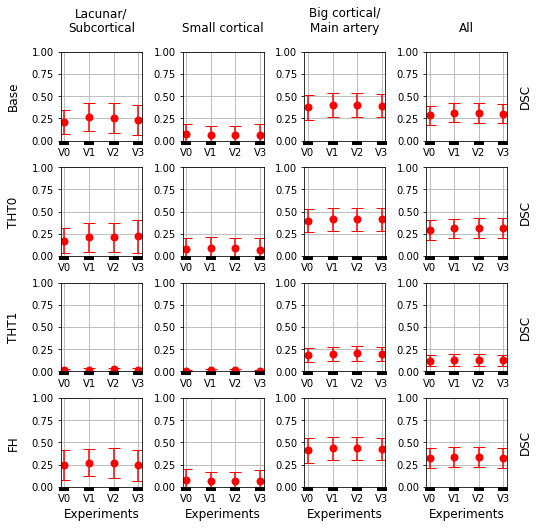

In [9]:
row_labels = ['Base', 'THT0', 'THT1', 'FH']
col_labels = ['Lacunar/\nSubcortical', 'Small cortical', 'Big cortical/\nMain artery', 'All']

x_labels = ['V0', 'V1', 'V2', 'V3']

plt.close('all')
rows, cols = [4, 4]
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(2*cols, 2*rows))

for ax, col in zip(axes[0], col_labels):
    ax.set_title(col, pad=20, size=12)

for ax, row in zip(axes[:,0], row_labels):
    ax.set_ylabel(row, rotation='vertical', size=12)
    ax.yaxis.set_label_coords(-0.5, 0.5)

for i in range(rows):
    for j in range(1,cols+1):
        # Compute mean and confidence interval
        metrics = np.array([[x[0] for x in summary_table_metrics['V0'][str(i)][str(j)]],
                            [x[0] for x in summary_table_metrics['V1'][str(i)][str(j)]],
                            [x[0] for x in summary_table_metrics['V2'][str(i)][str(j)]],
                            [x[0] for x in summary_table_metrics['V3'][str(i)][str(j)]]]).T
        
        mean = np.mean(metrics, axis=0)
        confidence_interval = st.t.interval(0.95, len(metrics[0])-1,
                                            loc=mean, scale=st.sem(metrics, axis=0))
        differences = (abs(confidence_interval[0] - mean), abs(confidence_interval[1] - mean))
        
        # Plot error bar
        axes[i,j-1].grid()
        axes[i,j-1].set_ylim([0,1])
        axes[i,j-1].tick_params(axis='x', width=10)
        (_, caps, _) = axes[i,j-1].errorbar(x_labels, mean, differences,
                                    color='red', mew=5,
                                    fmt='o', markersize=3, capsize=6)

        for cap in caps:
            cap.set_markeredgewidth(1)
            
        if j == cols:
            axes[i,j-1].set_ylabel('DSC', size=12)
            axes[i,j-1].yaxis.set_label_coords(1.3, 0.5)

        if i == rows-1:
            axes[i,j-1].set_xlabel('Experiments', size=12)

plt.subplots_adjust(hspace=0.3, wspace=0.5)
plt.savefig(os.path.join(root, 'summary_error_bars.pdf'), bbox_inches='tight')